In [77]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import json
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix


pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 300

## Predicting "Greenness" Of Content

This dataset comes from [stumbleupon](https://www.stumbleupon.com/), a web page recommender and was made available [here](https://www.kaggle.com/c/stumbleupon/download/train.tsv)

A description of the columns is below

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at www.alchemyapi.com)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at www.alchemyapi.com)
avglinksize| double|Average number of words in each link
commonLinkRatio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonLinkRatio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonLinkRatio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonLinkRatio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of <embed> usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an <a> with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of <img> tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 <a> 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer Number of <a>|markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

### What are 'evergreen' sites?
- These are websites that always relevant like recipies or reviews (as opposed to current events)
- Look at some examples

In [82]:
data = pd.read_csv('train.csv', sep='\t', na_values='?')

# Extract the title and body from the boilerplate JSON text
# data['title'] = data.boilerplate.map(lambda x: json.loads(x).get('title', ''))
# data['body'] = data.boilerplate.map(lambda x: json.loads(x).get('body', ''))

In [88]:
#data[['title', 'label']].head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395 entries, 0 to 7394
Data columns (total 27 columns):
url                               7395 non-null object
urlid                             7395 non-null int64
boilerplate                       7395 non-null object
alchemy_category                  5053 non-null object
alchemy_category_score            5053 non-null float64
avglinksize                       7395 non-null float64
commonlinkratio_1                 7395 non-null float64
commonlinkratio_2                 7395 non-null float64
commonlinkratio_3                 7395 non-null float64
commonlinkratio_4                 7395 non-null float64
compression_ratio                 7395 non-null float64
embed_ratio                       7395 non-null float64
framebased                        7395 non-null int64
frameTagRatio                     7395 non-null float64
hasDomainLink                     7395 non-null int64
html_ratio                        7395 non-null float64
image_

#### Build a feature matrix where X contains useful features and y contains the target variable `label`

In [178]:
from sklearn import preprocessing
# drop non numeric and non binary for features
features = data.drop(['url','urlid','boilerplate','alchemy_category'], axis = 1)

#all non null are 1.0, so nans must be 0.0
features['is_news'] = features['is_news'].fillna(0)
# If we don't know it is front page just assume it is not
features['news_front_page'] = features['news_front_page'].fillna(0)
#I'd rather drop alch score than lose the 2k data in other columns. I don't think replacing with mean is appropriate
features = features.drop('alchemy_category_score', axis = 1)

# Tried normalizing but it completely broke the model
columns = features.columns.values


features.head()

,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
0,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1.0,1,24,0.0,5424,170,8,0.152941,0.079130,0
1,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0,0.098707,0,0.203490,0.088652,1.0,1,40,0.0,4973,187,9,0.181818,0.125448,1
2,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0,0.072448,0,0.226402,0.120536,1.0,1,55,0.0,2240,258,11,0.166667,0.057613,1
3,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,0,0.095861,0,0.265656,0.035343,1.0,0,24,0.0,2737,120,5,0.041667,0.100858,1
4,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.0,0,0.024908,0,0.228887,0.050473,1.0,1,14,0.0,12032,162,10,0.098765,0.082569,0


#### Build a Logistic Regression model using scikit-learn
- Examine the coefficients using the `examine_coefficients` function provided
- Evaluate the AUC, precision and recall of the model using cross-validation (hint:use scoring parameter in cross_val_score
- Plot the ROC curve
- Iterate on the model by adding in additional features in `X` above

In [186]:
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt
%matplotlib inline

def modeler(features,y):
    X = features

    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, stratify=y,random_state=77)
    
    # Get predictions
    logreg = LogisticRegression(random_state=77)
    logreg.fit(X_train, Y_train)
    Y_pred = logreg.predict(X_test)

    # cnf matrix of predicted values and actual values
    conmat = np.array(confusion_matrix(Y_test, Y_pred, labels=[1,0]))
    confusion = pd.DataFrame(conmat, index=['is_green', 'not_green'],
                         columns=['predicted_green','predicted_not_green'])
    
    print(confusion)
    
    Y_proba_score = logreg.predict_proba(X_test)

    FPR, TPR, thresholds = roc_curve(Y_test, Y_proba_score[:,1])
    print(classification_report(Y_test, Y_pred))

    print "FPR"
    print FPR
    print "TPR"
    print TPR

    def examine_coefficients(model, df):
        return pd.DataFrame(
            { 'Coefficient' : model.coef_[0] , 'Feature' : df.columns}
        ).sort_values(by='Coefficient')

    examine_coefficients(logreg, X)
    
    
    ROC_AUC = auc(FPR, TPR)

    # Plot of a ROC curve for is_green
    plt.figure(figsize=[5,5])
    plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('ROC for greenness', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

y = features['label']


           predicted_green  predicted_not_green
is_green               872                  381
not_green              566                  622
             precision    recall  f1-score   support

          0       0.62      0.52      0.57      1188
          1       0.61      0.70      0.65      1253

avg / total       0.61      0.61      0.61      2441

FPR
[  0.00000000e+00   0.00000000e+00   8.41750842e-04 ...,   9.97474747e-01
   1.00000000e+00   1.00000000e+00]
TPR
[  7.98084597e-04   5.58659218e-03   5.58659218e-03 ...,   9.97605746e-01
   9.97605746e-01   1.00000000e+00]


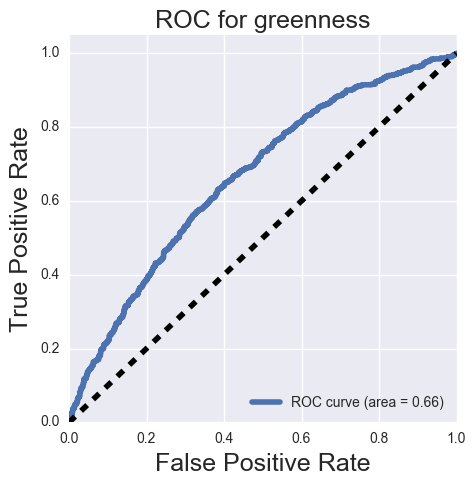

In [185]:
#All of the features
modeler(features.drop('label',axis = 1),y)

           predicted_green  predicted_not_green
is_green               878                  375
not_green              659                  529
             precision    recall  f1-score   support

          0       0.59      0.45      0.51      1188
          1       0.57      0.70      0.63      1253

avg / total       0.58      0.58      0.57      2441

FPR
[  0.00000000e+00   0.00000000e+00   8.41750842e-04 ...,   9.99158249e-01
   9.99158249e-01   1.00000000e+00]
TPR
[  7.98084597e-04   4.78850758e-03   4.78850758e-03 ...,   9.98403831e-01
   1.00000000e+00   1.00000000e+00]


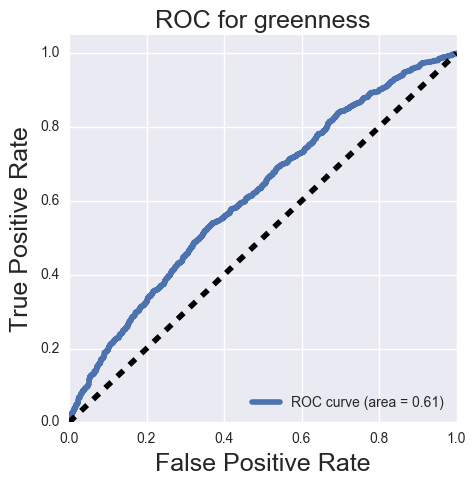

In [188]:
# Took top 3 correlations and dropped one that had a coef close to 0
modeler(features[['frameTagRatio','commonlinkratio_3']],y)

           predicted_green  predicted_not_green
is_green               783                  470
not_green              586                  602
             precision    recall  f1-score   support

          0       0.56      0.51      0.53      1188
          1       0.57      0.62      0.60      1253

avg / total       0.57      0.57      0.57      2441

FPR
[  0.00000000e+00   0.00000000e+00   8.41750842e-04 ...,   9.56228956e-01
   9.60437710e-01   1.00000000e+00]
TPR
[  7.98084597e-04   2.39425379e-03   2.39425379e-03 ...,   9.87230646e-01
   9.87230646e-01   1.00000000e+00]


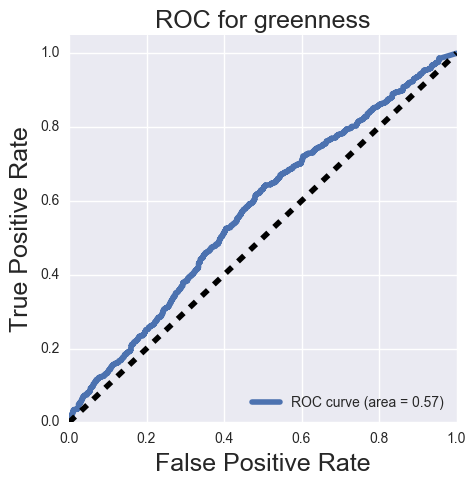

In [190]:
# all common link ratio featurs
modeler(features[['commonlinkratio_1', 'commonlinkratio_2',
       'commonlinkratio_3', 'commonlinkratio_4']],y)

           predicted_green  predicted_not_green
is_green               808                  445
not_green              595                  593
             precision    recall  f1-score   support

          0       0.57      0.50      0.53      1188
          1       0.58      0.64      0.61      1253

avg / total       0.57      0.57      0.57      2441

FPR
[  0.00000000e+00   8.41750842e-04   8.41750842e-04 ...,   9.95791246e-01
   1.00000000e+00   1.00000000e+00]
TPR
[ 0.          0.          0.00558659 ...,  0.99840383  0.99840383  1.        ]


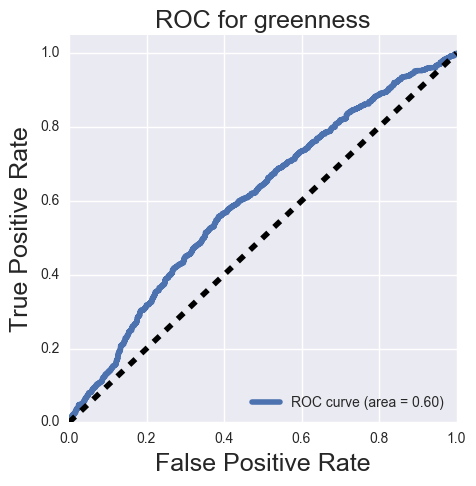

In [192]:
#features that start with n
modeler(features[['news_front_page',
       'non_markup_alphanum_characters', 'numberOfLinks',
       'numwords_in_url']],y)

           predicted_green  predicted_not_green
is_green               635                  618
not_green              611                  577
             precision    recall  f1-score   support

          0       0.48      0.49      0.48      1188
          1       0.51      0.51      0.51      1253

avg / total       0.50      0.50      0.50      2441

FPR
[ 0.  1.]
TPR
[ 0.  1.]


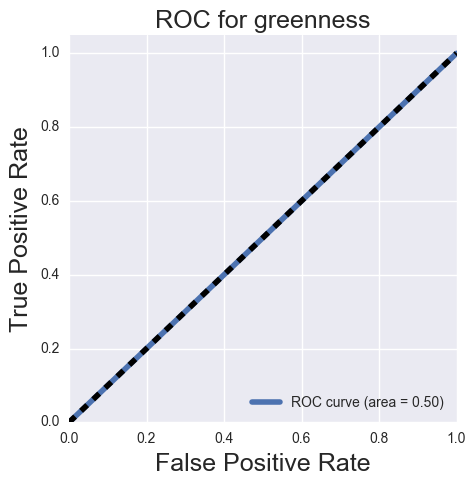

In [198]:
from sklearn.dummy import DummyClassifier
def dummy_modeler(features,y):
    X = features

    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, stratify=y,random_state=77)
    
    # dummy classifier instead of logreg classifier
    clf = DummyClassifier(strategy='uniform',random_state=0)
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)

    # cnf matrix of predicted values and actual values
    conmat = np.array(confusion_matrix(Y_test, Y_pred, labels=[1,0]))
    confusion = pd.DataFrame(conmat, index=['is_green', 'not_green'],
                         columns=['predicted_green','predicted_not_green'])
    
    print(confusion)
    
    Y_proba_score = clf.predict_proba(X_test)

    FPR, TPR, thresholds = roc_curve(Y_test, Y_proba_score[:,1])
    print(classification_report(Y_test, Y_pred))

    print "FPR"
    print FPR
    print "TPR"
    print TPR
    
    ROC_AUC = auc(FPR, TPR)

    # Plot of a ROC curve for is_green
    plt.figure(figsize=[5,5])
    plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('ROC for greenness', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

y = features['label']

dummy_modeler(features.drop('label',axis = 1),y)